In [42]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [43]:
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")

In [44]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [45]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

# Стаблизация графика Dowjones из ДЗ1

In [46]:
dowjones_closing0 = dowjones_closing.ix[:,0]
dowjones_closing1 = dowjones_closing.ix[:,1]
data=[]
index=[]

for w0 in dowjones_closing0.values:
    index.append(w0)
for w0 in dowjones_closing1.values:
    data.append(float(w0))
dowjones_closing_ready = pd.Series(data = data, index = index)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


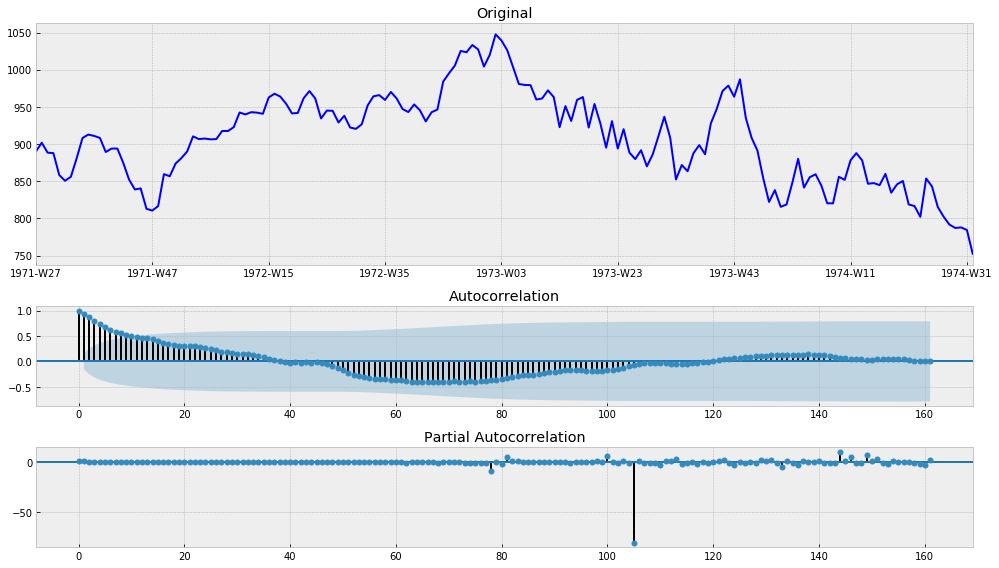

In [47]:
tsplot(dowjones_closing_ready)

In [48]:
dowjones_closing_ready_bx = boxcox(dowjones_closing_ready, 1)

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


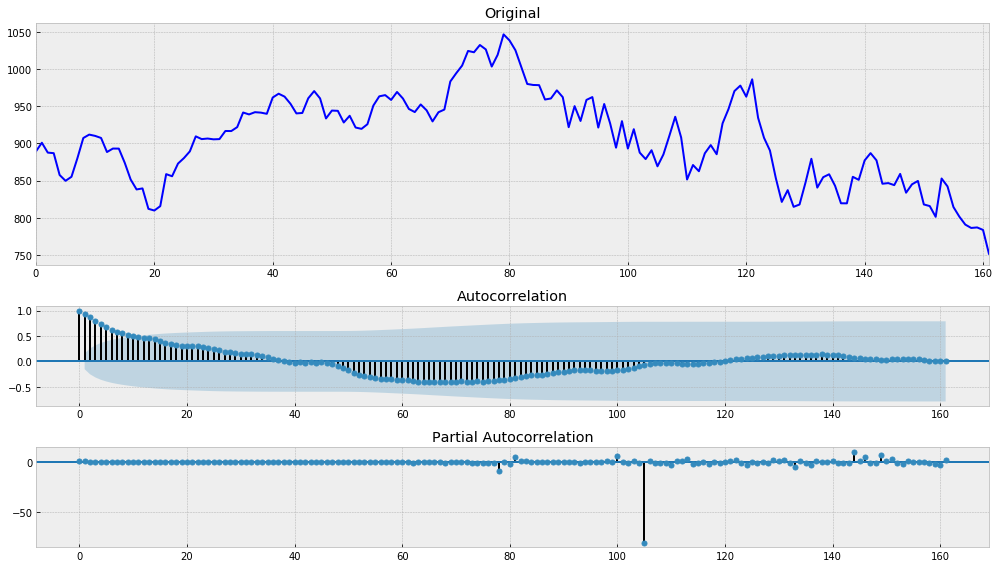

In [49]:
tsplot(dowjones_closing_ready_bx)

In [50]:
dowjones_closing_ready_df = np.diff(dowjones_closing_ready_bx, 1)

Results of Dickey-Fuller Test:
Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


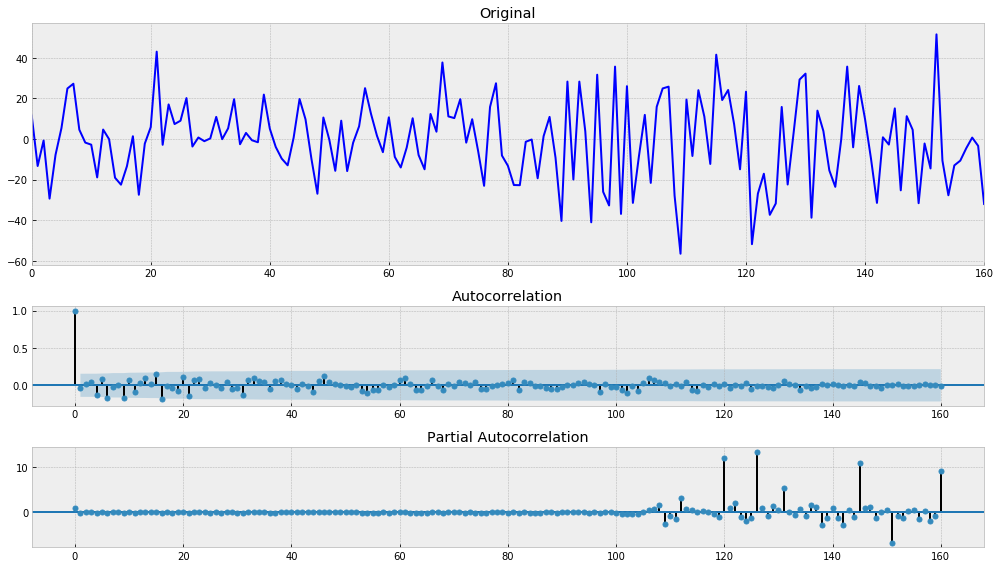

In [51]:
tsplot(dowjones_closing_ready_df)

# Double EMA

In [75]:
## вариант со стаблизацией

series = dowjones_closing_ready_df

In [76]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [77]:
def plot_dema(alpha, beta):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

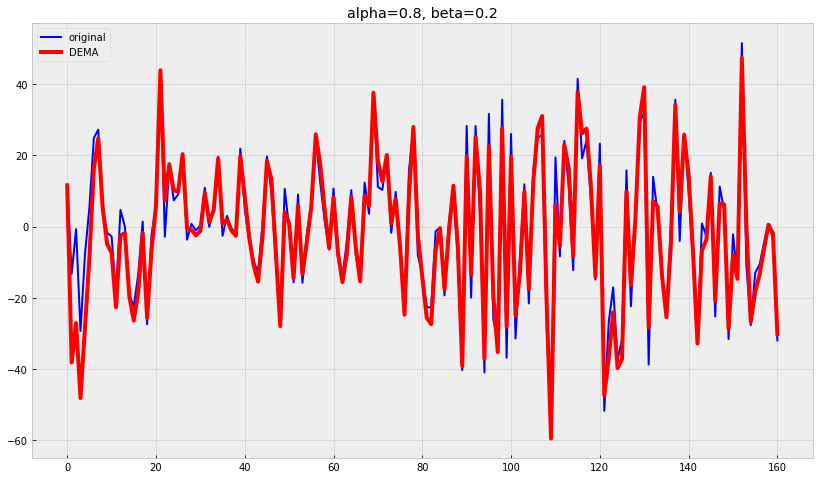

In [78]:
plot_dema(0.8, 0.2)

In [79]:
## нестаблизированный вариант

series = dowjones_closing_ready

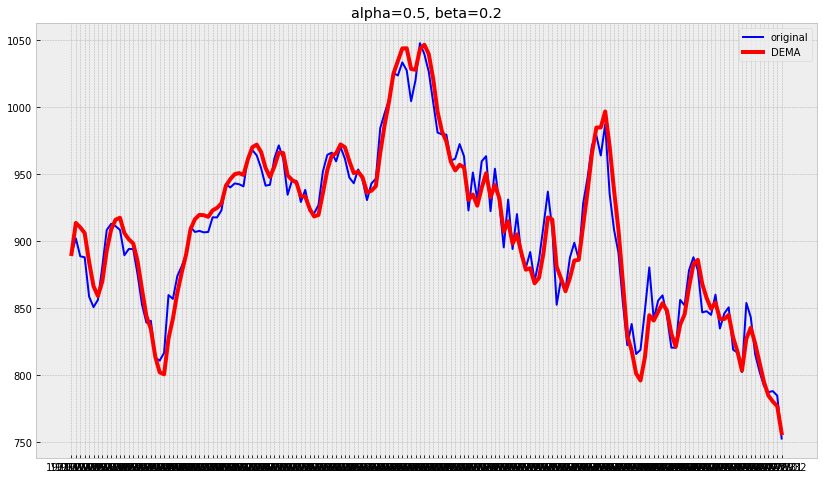

In [80]:
plot_dema(0.5, 0.2)

# Экспоненциальное сглаживание

In [94]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [95]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [96]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [97]:
## вариант со стаблизацией

series = dowjones_closing_ready_df

In [98]:
ema = exponential_moving_average(series, 0.2)

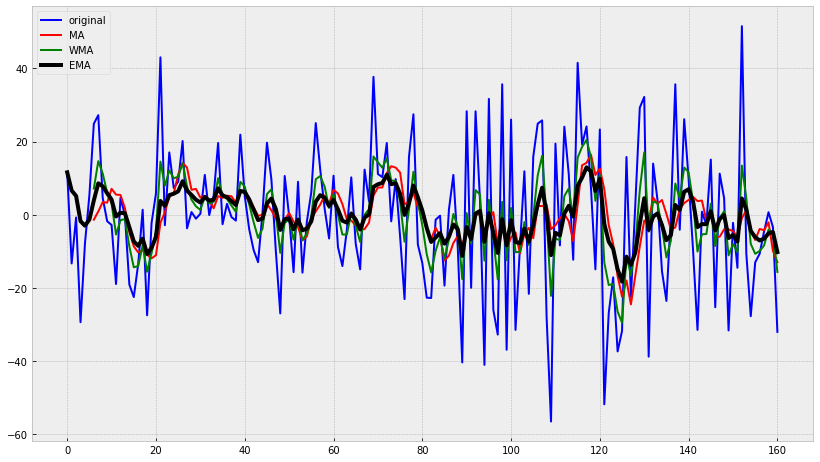

In [99]:
ema = exponential_moving_average(series, 0.2)
wma = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
ma = moving_average(series, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

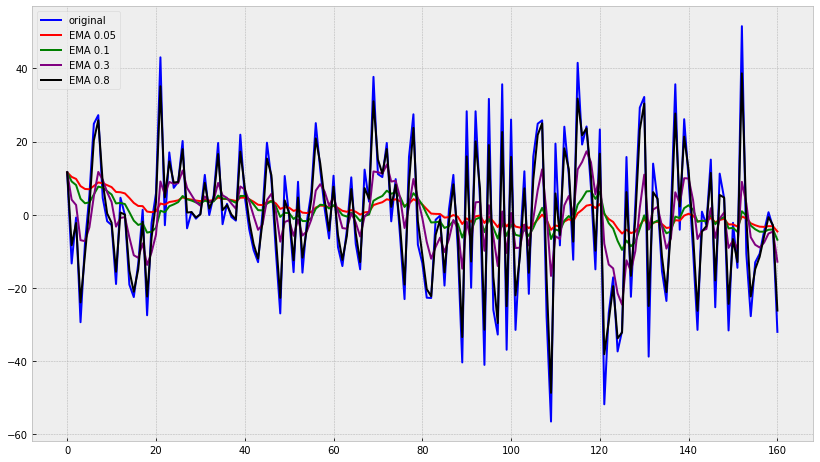

In [100]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(series, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

In [101]:
## нестаблизированный вариант

series = dowjones_closing_ready

In [102]:
ema = exponential_moving_average(series, 0.2)

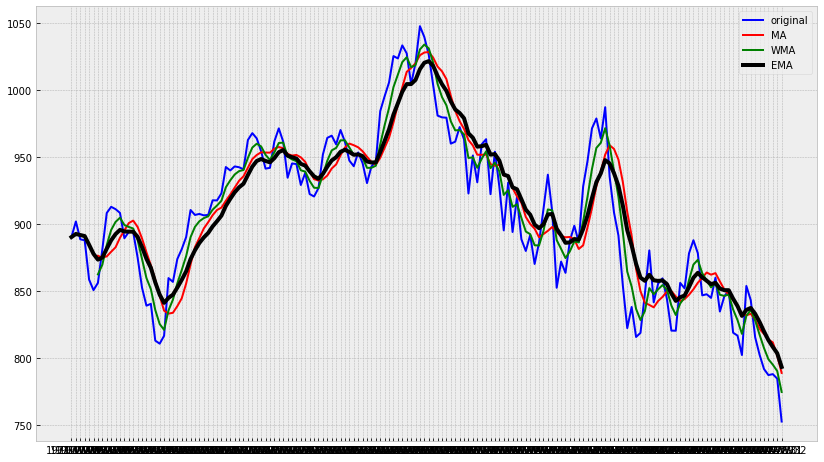

In [103]:
ema = exponential_moving_average(series, 0.2)
wma = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
ma = moving_average(series, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

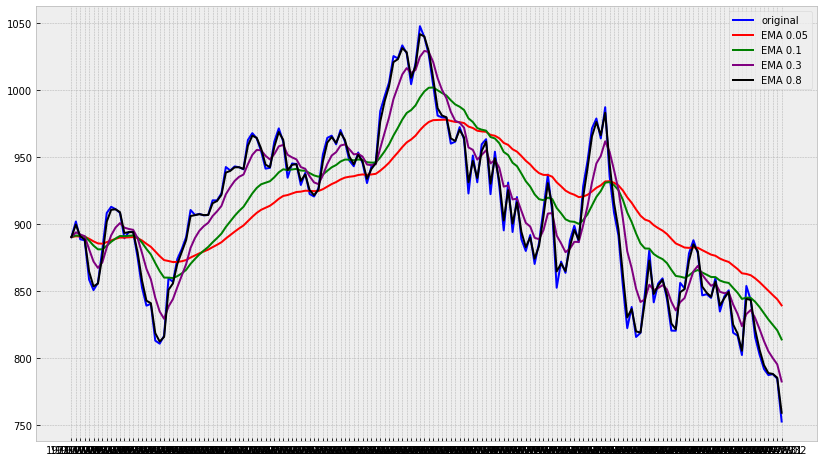

In [104]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(series, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

# Признаться честно, я не понимаю как анализировать полученные результаты, если конечно я правильно выполнил задание )